In [2]:
import pandas as pd   
import json          
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import requests


#1. Load csv file
csv_file = 'csv_to_convert.csv'
annotation_df = pd.read_csv(csv_file)


In [24]:
annotation_df.info() #check data type and determine missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             6 non-null      int64  
 1   agent_id_ext                   6 non-null      object 
 2   agent_name                     6 non-null      object 
 3   universal_client_project_code  6 non-null      object 
 4   date                           6 non-null      object 
 5   duration                       0 non-null      float64
 6   pm_name                        0 non-null      float64
 7   image_annotation_count         6 non-null      int64  
 8   image_annotation_data          6 non-null      object 
 9   image_annotation_url           6 non-null      object 
 10  status                         0 non-null      float64
 11  annotation_parsed              6 non-null      object 
dtypes: float64(3), int64(2), object(7)
memory usage: 708.0

In [3]:
#Load csv file
csv_file = 'csv_to_convert.csv'
annotation_df = pd.read_csv(csv_file)

#convert JSON string in 'image_annotation_data' in phyton to easy the process
annotation_df['annotation_parsed'] = annotation_df['image_annotation_data'].apply(json.loads)


In [4]:
#COCO format standard ada 3 bahagian:
#images - info gambar
#annotations - info rectangle/polygon
#categories - label/category setiap annotation
coco_format = {
    "images": [],
    "annotations": [],
    "categories": []
}


In [5]:
category_map = {}  # untuk map label ke ID
category_id_counter = 1
annotation_id = 1  # ID unik untuk setiap annotation
annotation_df.head()

,id,agent_id_ext,agent_name,universal_client_project_code,date,duration,pm_name,image_annotation_count,image_annotation_data,image_annotation_url,status,annotation_parsed
0,633205,44dc3399-b24e-4339-9e96-6098a2943784,Gee Thek,e8294350-3ea4-4ce9-8b15-582b0a49b2ba,2025-06-19T00:00:00.000Z,NaN,NaN,1,"[{""points"":[[{""x"":54.21484375,""y"":179.8515625}...",https://saas-uploads-dev.s3.ap-southeast-1.ama...,NaN,"[{'points': [[{'x': 54.21484375, 'y': 179.8515..."
1,633206,44dc3399-b24e-4339-9e96-6098a2943784,Gee Thek,e8294350-3ea4-4ce9-8b15-582b0a49b2ba,2025-06-19T00:00:00.000Z,NaN,NaN,4,"[{""points"":[[{""x"":43.03125,""y"":151.2578125},{""...",https://saas-uploads-dev.s3.ap-southeast-1.ama...,NaN,"[{'points': [[{'x': 43.03125, 'y': 151.2578125..."
2,633207,44dc3399-b24e-4339-9e96-6098a2943784,Gee Thek,e8294350-3ea4-4ce9-8b15-582b0a49b2ba,2025-06-19T00:00:00.000Z,NaN,NaN,3,"[{""points"":[{""x"":90.97265625,""y"":116.55859375}...",https://saas-uploads-dev.s3.ap-southeast-1.ama...,NaN,"[{'points': [{'x': 90.97265625, 'y': 116.55859..."
3,633208,44dc3399-b24e-4339-9e96-6098a2943784,Gee Thek,e8294350-3ea4-4ce9-8b15-582b0a49b2ba,2025-06-19T00:00:00.000Z,NaN,NaN,2,"[{""points"":[[{""x"":324.1015625,""y"":36.90625},{""...",https://saas-uploads-dev.s3.ap-southeast-1.ama...,NaN,"[{'points': [[{'x': 324.1015625, 'y': 36.90625..."
4,633209,44dc3399-b24e-4339-9e96-6098a2943784,Gee Thek,e8294350-3ea4-4ce9-8b15-582b0a49b2ba,2025-06-19T00:00:00.000Z,NaN,NaN,0,[],https://saas-uploads-dev.s3.ap-southeast-1.ama...,NaN,[]


In [6]:
for index_annotation, row_annotation in annotation_df.iterrows(): # Guna index and row data in loop
    # Tambah info gambar
    image_info = {
        "id": row_annotation['id'],
        "file_name": row_annotation['image_annotation_url'].split('/')[-1],  # ambil nama file dari URL
        "height": 0,  # optional, kalau takde data
        "width": 0
    }
    coco_format['images'].append(image_info)

    # Loop annotation dalam satu row
    for annotation in row_annotation['annotation_parsed']:
        label = annotation['options']['label']
        
        # Assign category ID automatik
        if label not in category_map:
            category_map[label] = category_id_counter
            coco_format['categories'].append({
                "id": category_id_counter,
                "name": label
            })
            category_id_counter += 1

        # Convert points ke bounding box [x_min, y_min, width, height]
        if isinstance(annotation['points'][0], list):  # polygon
            points = annotation['points'][0]
            x_coords = [p['x'] for p in points]
            y_coords = [p['y'] for p in points]
            x_min, y_min = min(x_coords), min(y_coords)
            x_max, y_max = max(x_coords), max(y_coords)
        else:  # rectangle
            points = annotation['points']
            x_min, y_min = points[0]['x'], points[0]['y']
            x_max, y_max = points[1]['x'], points[1]['y']

        bbox = [x_min, y_min, x_max-x_min, y_max-y_min]

        # Tambah annotation
        coco_format['annotations'].append({
            "id": annotation_id,
            "image_id": row_annotation['id'],
            "category_id": category_map[label],
            "bbox": bbox,
            "area": bbox[2]*bbox[3],
            "iscrowd": 0
        })
        annotation_id += 1


In [7]:
with open('coco_conversion.json', 'w') as coco:
    json.dump(coco_format, coco, indent=4)


In [8]:
issues = []

# Convert images list ke DataFrame untuk senang check
images_df = pd.DataFrame(coco_format['images'])

# 1️.Check setiap image ada annotation
# Buat mapping image_id -> list of annotations
from collections import defaultdict
image_annotations_map = defaultdict(list)
for ann in coco_format['annotations']:
    image_annotations_map[ann['image_id']].append(ann)

for img in coco_format['images']:
    img_id = img['id']
    # Flag image tanpa annotation
    if len(image_annotations_map.get(img_id, [])) == 0:
        issues.append(f"Image ID {img_id} has no annotation")

# 2️.Check duplicate image IDs
duplicate_images = images_df[images_df['id'].duplicated(keep=False)]
if not duplicate_images.empty:
    issues.append(f"Duplicate image IDs found: {duplicate_images['id'].tolist()}")

# 3️.Check missing image metadata
for img in coco_format['images']:
    if not img.get('file_name'):
        issues.append(f"Image ID {img['id']} missing file_name")
    if img.get('height', 0) == 0 or img.get('width', 0) == 0:
        issues.append(f"Image ID {img['id']} missing height/width")

# 4️.Check category ID mismatch
category_ids = {cat['id'] for cat in coco_format['categories']}
for ann in coco_format['annotations']:
    if ann['category_id'] not in category_ids:
        issues.append(f"Annotation ID {ann['id']} has invalid category_id {ann['category_id']}")

# Buat report
if not issues:
    report = {"issues": ["No issues found"]}
else:
    report = {"issues": issues}

# Simpan ke JSON
with open("validation_report.json", "w") as jsonReport:
    json.dump(report, jsonReport, indent=4)

print("Validation report saved to validation_report.json")


Validation report saved to validation_report.json


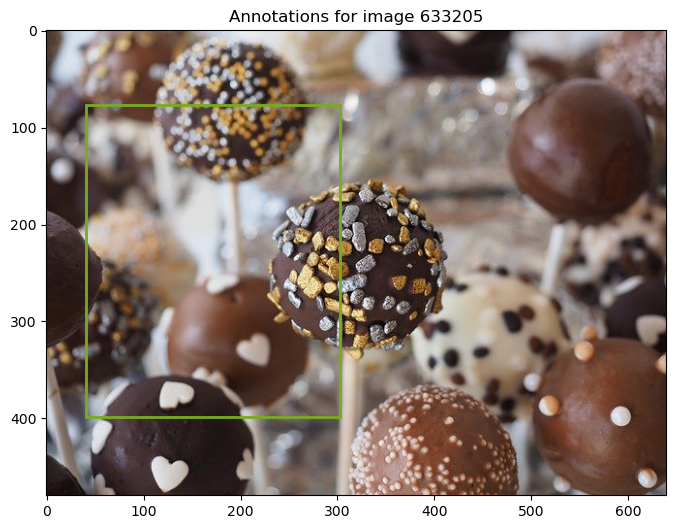

In [9]:
import pandas as pd   
import json 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

row = annotation_df.iloc[0]  # pilih row pertama

#download gambar dari URL ('image_annotation_url') 
response = requests.get(row['image_annotation_url'])
img = Image.open(BytesIO(response.content))

fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img)
ax.set_title(f"Annotations for image {row['id']}")

for ann in row['annotation_parsed']:
    label = ann['options']['label']
    color = ann['options'].get('color', '#ff0000')
    
    if isinstance(ann['points'][0], list):  # polygon
        points = ann['points'][0]
        x_coords = [p['x'] for p in points]
        y_coords = [p['y'] for p in points]
        rectangle = patches.Rectangle(
            (min(x_coords), min(y_coords)), 
            max(x_coords)-min(x_coords), 
            max(y_coords)-min(y_coords),
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rectangle)
    else:  # rectangle
        points = ann['points']
        rectangle = patches.Rectangle(
            (points[0]['x'], points[0]['y']),
            points[1]['x'] - points[0]['x'],
            points[1]['y'] - points[0]['y'],
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rectangle)

plt.show()


In [10]:
#annotation_df[annotation_df['id'].duplicated()]
# convert to string first
annotation_df['id'] = annotation_df['id'].astype(str)

# then strip whitespace (optional)
annotation_df['id'] = annotation_df['id'].str.strip()

# check duplicates
duplicate_rows = annotation_df[annotation_df['id'].duplicated(keep=False)]
print(duplicate_rows)


Empty DataFrame
Columns: [id, agent_id_ext, agent_name, universal_client_project_code, date, duration, pm_name, image_annotation_count, image_annotation_data, image_annotation_url, status, annotation_parsed]
Index: []


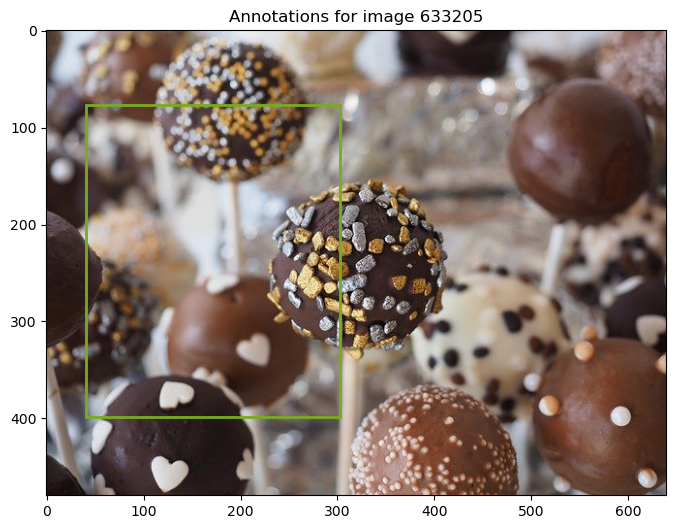

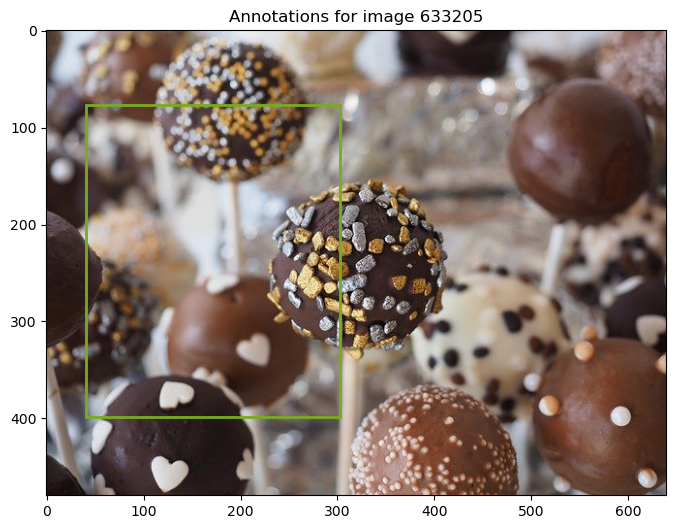

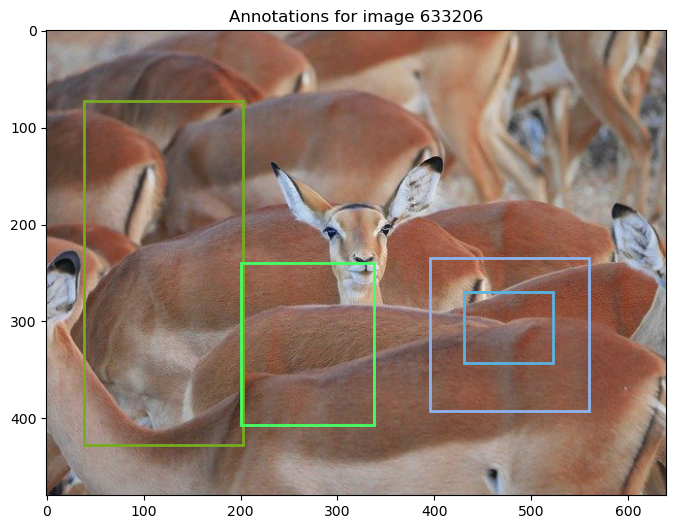

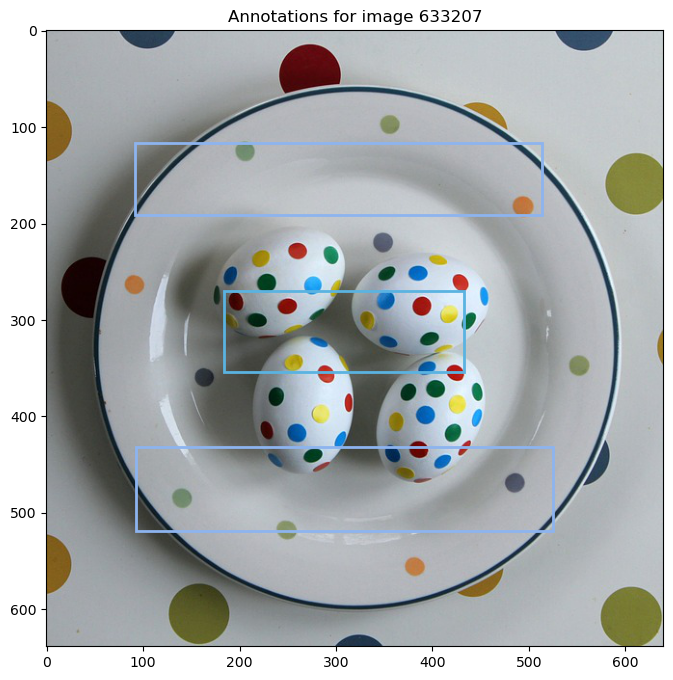

In [15]:
def visualize_annotation_row(row):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    
# Function used to load image from URL
    ax.imshow(Image.open(BytesIO(requests.get(row['image_annotation_url']).content)))
    ax.set_title(f"Annotations for image {row['id']}")

    for annotation_image in row['annotation_parsed']:
        label = annotation_image['options']['label']
        color = annotation_image['options'].get('color', '#ff0000')
        
#if else statement if the coordinates more than 2 print polygon
        if isinstance(annotation_image['points'][0], list):  
            points = annotation_image['points'][0]
            x_coords = [p['x'] for p in points]
            y_coords = [p['y'] for p in points]
            rectangle = patches.Rectangle(
                (min(x_coords), min(y_coords)),
                max(x_coords)-min(x_coords),
                max(y_coords)-min(y_coords),
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rectangle)
        else:  
#if coordinates lesser or equal 2 print rectangle
            points = annotation_image['points']
            rectangle = patches.Rectangle(
                (points[0]['x'], points[0]['y']),
                points[1]['x'] - points[0]['x'],
                points[1]['y'] - points[0]['y'],
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rectangle)

    plt.show()
    
# visualize first image
visualize_annotation_row(annotation_df.iloc[0])

# visualize multiple images
for i in range(3):
    visualize_annotation_row(annotation_df.iloc[i])


In [50]:
original_duplicate_ids = annotation_df['id'][annotation_df['id'].duplicated(keep=False)]
print(original_duplicate_ids)


Series([], Name: id, dtype: object)
